# PyCC Sequential Learning Tutorial

*Authors: Edward Kim, Enze Chen*

In this notebook, we will cover how to perform **sequential learning** (SL) using the [Citrination API](http://citrineinformatics.github.io/python-citrination-client/). [Sequential learning](https://citrine.io/platform/sequential-learning/) is the key workflow which allows machine learning algorithms and in-lab experiments to iteratively inform each other.

To replace the need for an actual laboratory, this notebook uses a simple *toy function* that allows for "measurements" on the data.

**NOTE**: If you want to run the sequential learning code in the final part of this tutorial on the public version of Citrination (https://citrination.com), then you will need an admin account to run design jobs.

## Learning objectives

By the end of this tutorial, you will know how to:

- Use PyCC end to end, from uploading an initial dataset to running SL
- Understand how to configure SL parameters to match your laboratory setup
- Asynchronously issue SL jobs to Citrination's backend

## Background knowledge

In order to get the most out of this tutorial, you should already be familiar with the following:

- Create and access datasets through the API ([tutorial](1_data_client_api_tutorial.ipynb))
- Create and access data views through the API ([tutorial](2_data_views_api_tutorial.ipynb))
- What the data views [front-end UI](https://citrination.com/data_views) looks like, particularly the Design interface

## Imports
This notebook uses some convenience functions to wrap several API endpoints. These are listed in the file [`sl_wrappers.py`](./sl_wrappers.py) and imported below. Review the docstrings and code in that file to learn more.

In [2]:
# Standard packages
from os import environ
from time import sleep

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sl_wrappers import *   # Helper functions to wrap several API endpoints together
# from pypif import pif
# from pypif.obj import *
# from citrination_client import CitrinationClient
# from citrination_client.models.design import Target

sns.set_context("talk")
sns.set_style("whitegrid")

## Setting up a client

Make sure to properly set your **environment variable** to hold your API key.

In [3]:
client = CitrinationClient(
    environ.get("CITRINATION_API_KEY_PUBLIC"),
    "https://citrination.com"
)

## Data generation

Since we aren't using a real laboratory, we need access to a quick way to generate "correct" measurements. A simple placeholder here is to use a function that sums the squares of its inputs. The goal, in this case, will be to find the global minimum located at the origin. 

In a real example, we could minimize or maximize any output: compressive strengths, conductivities, and so on.

In [4]:
def toy_func(inputs):
    func_sum = 0.0
    for inp in inputs:
        func_sum += inp**2
    return func_sum

toy_x = [np.random.normal(loc=2.0, scale=1.0, size=(1, 2))[0] for x in range(20)]
toy_y = [toy_func(x) for x in toy_x]

initial_best_measured_value = min(toy_y)

print(f"Best (lowest) value in initial training set: {initial_best_measured_value}")

Best (lowest) value in initial training set: 2.427999115971243


Now we can plot the initial training set, and color it by the function value.

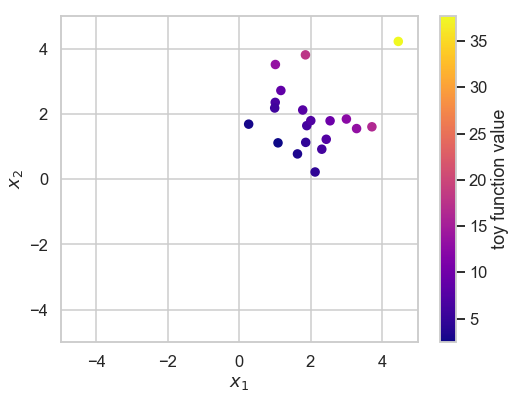

In [5]:
# Plot initial training set, colored by toy function values

plt.rcParams.update({'figure.figsize':(8, 6), 'lines.markersize':8})
plt.scatter(np.array(toy_x)[:,0], np.array(toy_x)[:,1],
            c=toy_y, cmap=plt.cm.plasma)
plt.colorbar(label='toy function value')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [6]:
# Write a PIF JSON dataset file
write_dataset_from_func(toy_func, "toy_initial_dataset.json", toy_x)

In [24]:
# Make a dataset, upload to Citrination, return/print the ID

dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
#   given_dataset_id=1234
)
print(f"Dataset created: {dataset_id}")

Dataset created: 174174


In [25]:
# Make a data view on Citrination, return/print the ID

view_id = build_view_and_get_id(client, dataset_id, "toy_view", view_desc="toy test view",
                      input_keys=["Property x1", "Property x2"], output_keys=["Property y"])

print(f"Data view created: {view_id}")

Data view created: 8378


If this is not your first time running this notebook, you can change the following variables to match what you've already created.

In [17]:
# dataset_id = 123456
# view_id = 1234

# Running design

Now we call a function that runs the SL process. In short, we run a loop where we do the following:

1. Submit a design run (and poll status w/ wait times)
1. Get best candidates and record predicted results
1. Measure candidates (using toy function evaluation) and record measured results
1. Add candidates to dataset
1. Retrain on dataset (and poll status w/ wait times)
1. Repeat until max iterations reached

Detailed comments can be found in the [function docstring](sl_wrappers.py).

In [26]:
sl_results = {}

best_sl_pred_vals, best_sl_measured_vals = run_sequential_learning(
    client=client,
    view_id=str(view_id),
    dataset_id=str(dataset_id),
    num_candidates_per_iter=10,
    design_effort=20,
    wait_time=5,
    num_sl_iterations=5,
    input_properties=["Property x1", "Property x2"],
    target=["Property y", "Min"],
    print_output=True,
    true_function=toy_func,
    score_type="MLI"
)

# Reset dataset after each SL run
dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
    given_dataset_id=dataset_id
)

sl_results["predicted"] = best_sl_pred_vals
sl_results["measured"] = best_sl_measured_vals


---STARTING SL ITERATION #1---
Design ready
Created design run with ID 48f43f61-eb86-4e2b-99ac-b5ad236b1527
Design run status: Accepted
Design run status: Accepted
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #1, best predicted (value, uncertainty) = ('10.821031435896407', '0.0')
Dataset updated: 10 candidates added
New dataset contains 30 PIFs
Design ready

---STARTING SL ITERATION #2---
Design ready
Created design run with ID 65d2b0ea-d220-4491-b717-b8016051d6e0
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #2, best predicted (value, uncertainty) = ('1.58', '0.76')
Dataset updated: 10 candidates added
New dataset contains 38 PIFs
Design ready

---STARTING SL ITERATION #3---
Design ready
Created design run with ID 7bc15832-1a0c-4717-ab4a-ad916d6cc829
Design run status: A

## Examining the results

Finally, we can plot the results: Here, we are plotting the best measured candidate against the number of SL iterations. In this case, lower = better for the measured results (since we are doing function minimization).

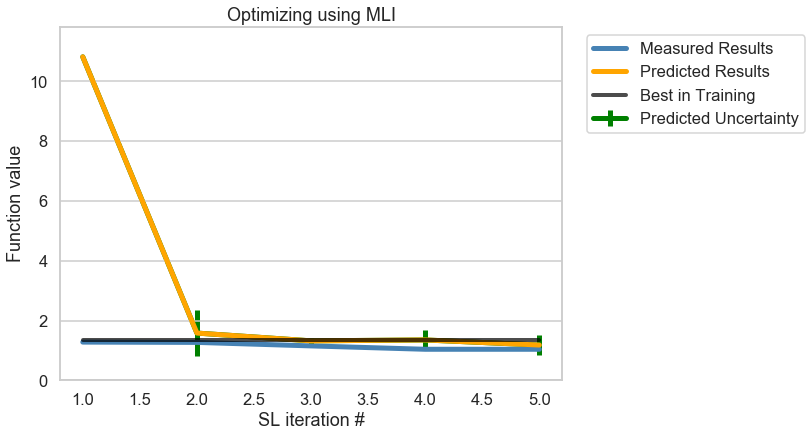

In [54]:
# Measured results
sns.lineplot(
    x=np.arange(1, len(sl_results["measured"])+1),
    y=[round(float(v), 3) for v in sl_results["measured"]],
    lw=5,
    estimator=None,
    markers=True,
    color="steelblue",
    label=f"Measured Results",
    legend=False,

)

# Predicted results
predicted_ax = sns.lineplot(
    x=np.arange(1, len(sl_results["predicted"])+1),
    y=[round(float(v[0]), 3) for v in sl_results["predicted"]],
    lw=5,
    estimator=None,
    markers=True,
    color="orange",
    label=f"Predicted Results",
    legend=False,

)

# Error bars
predicted_ax.errorbar(
    np.arange(1, len(sl_results["predicted"])+1), 
    [round(float(v[0]), 3) for v in sl_results["predicted"]], 
    yerr=[round(float(v[1]), 3) for v in sl_results["predicted"]],
    lw=5,
    color="green",
    ecolor=["green"]*5,
    label="Predicted Uncertainty",
    fmt='', 
    zorder=-1
)

# Best candidate in training set
sns.lineplot(
    x=np.arange(1, 6),
    y=[initial_best_measured_value]*5,
    estimator=None,
    markers=False,
    label=f"Best in Training",
    legend=False,
    color="black",
    lw=4,
    alpha=0.7
)


plt.xlabel("SL iteration #")
plt.legend(loc='best', bbox_to_anchor=(1.5, 1.0))
plt.ylabel("Function value")
plt.ylim([0, float(sl_results['predicted'][0][0])+1])
plt.title(f"Optimizing using MLI")
plt.grid(b=False, axis='x')
plt.show()

## Conclusion
To recap, this notebook went through the steps for running SL using the API.
1. First, we created and uploaded an initial dataset.
1. Then, we created a data view and trained the model.
1. We ran the SL process, measuring and updating new candidates after each iteration.
1. Finally we examined our SL results.

## Additional resources
It's now possible to conduct the major aspects of the Citrination workflow through the API, which should increase the speed and flexibility of informatics approaches. Some other topics that might interest you include:
* [DataClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) - This allows you to create datasets and upload PIF data (only) using the API.
  * There is also a corresponding [tutorial](1_data_client_api_tutorial.ipynb).

* [DataViewsClient](https://github.com/CitrineInformatics/python-citrination-client/tree/develop/citrination_client/views) - This allows you to build views (i.e. train ML models) using the API.
  * There is also a corresponding [tutorial](2_data_views_api_tutorial.ipynb).